In [1]:
# Hierarchical clustering in scikit‑learn (detailed example)
# ----------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine          # any tabular data will do
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine
X_raw = load_wine(as_frame=True).frame         # 178 × 13
coords = X_raw[['color_intensity', 'hue']].values  # pick 2 numeric features


In [5]:
X_raw.info(memory_usage='deep')
X_raw.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

(178, 14)

In [6]:
X_raw.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [7]:
##dataframe memory optimization

float_cols = X_raw.select_dtypes(include=['float64']).columns
int_cols = X_raw.select_dtypes(include=['int64']).columns

X_raw[float_cols] = X_raw[float_cols].astype('float32')
X_raw[int_cols] = X_raw[int_cols].astype('int32')

print("Memory optimization of column types:")
X_raw.info(memory_usage='deep')

Memory optimization of column types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float32
 1   malic_acid                    178 non-null    float32
 2   ash                           178 non-null    float32
 3   alcalinity_of_ash             178 non-null    float32
 4   magnesium                     178 non-null    float32
 5   total_phenols                 178 non-null    float32
 6   flavanoids                    178 non-null    float32
 7   nonflavanoid_phenols          178 non-null    float32
 8   proanthocyanins               178 non-null    float32
 9   color_intensity               178 non-null    float32
 10  hue                           178 non-null    float32
 11  od280/od315_of_diluted_wines  178 non-null    float32
 12  proline                    

In [8]:
X_raw.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [9]:
##Target imbalance
X_raw['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [10]:
##Missing value summary
missing_pct = X_raw.isna().mean().sort_values(ascending=False)
print(missing_pct[missing_pct>0])

Series([], dtype: float64)


In [12]:
##Categorical Cardinality
cat_cols = X_raw.select_dtypes(include=['object']).columns
X_raw[cat_cols].nunique().sort_values(ascending=False)

Series([], dtype: float64)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [14]:
# -------------------------------------------------------------------
# 1. Load data (built‑in Wine – 178 samples × 13 numeric features)
# -------------------------------------------------------------------
wine = load_wine(as_frame=True)
X_all = wine.frame
print(f"Original shape: {X_all.shape}")

Original shape: (178, 14)


In [15]:
# Choose any two continuous features for easy 2‑D visualisation.
# (You can keep all features – DBSCAN works in higher dims too.)
feat1, feat2 = "color_intensity", "hue"
X = X_all[[feat1, feat2]].values

In [16]:
# -------------------------------------------------------------------
# 2. Scale features (distance‑based algorithms need comparable scales)
# -------------------------------------------------------------------
X_scaled = StandardScaler().fit_transform(X)

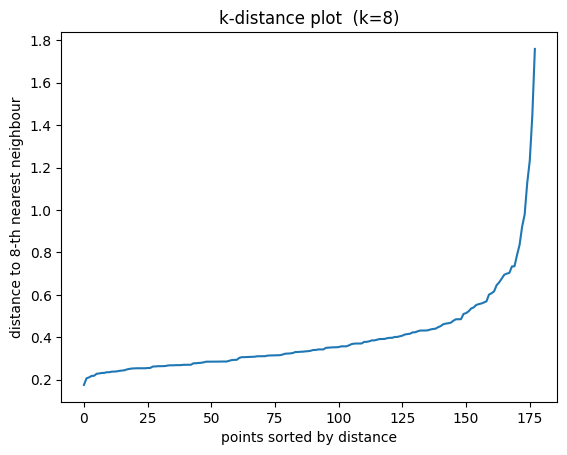

In [17]:
# -------------------------------------------------------------------
# 3. k‑distance plot to pick eps  ➜  elbow ≈ optimal radius
#    k = min_samples  (rule‑of‑thumb: 5–10)
# -------------------------------------------------------------------
min_samples = 8
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])          # distance to k‑th NN

plt.figure()
plt.plot(k_distances)
plt.title(f"k‑distance plot  (k={min_samples})")
plt.xlabel("points sorted by distance")
plt.ylabel(f"distance to {min_samples}‑th nearest neighbour")
plt.show()

In [18]:
# ⇣  Manually inspect the elbow on the curve.  Suppose it’s ~0.3
eps = 0.30

# -------------------------------------------------------------------
# 4. Fit DBSCAN
# -------------------------------------------------------------------
db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

In [19]:
# Metrics
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)
sil        = silhouette_score(X_scaled, labels) if n_clusters > 1 else np.nan

print(f"\nDBSCAN results (eps={eps}, min_samples={min_samples})")
print(f" • clusters found : {n_clusters}")
print(f" • noise points   : {n_noise}")
print(f" • silhouette     : {sil:.3f}")


DBSCAN results (eps=0.3, min_samples=8)
 • clusters found : 2
 • noise points   : 74
 • silhouette     : 0.064
